<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 45px">

# Capstone Project: Multi-Label Text classification for Trust and Safety (Content moderation) - Part 1 (Data cleaning, EDA)

DISCLAIMER: THIS PROJECT CONTAINS TEXTS WITH COARSE AND ADULT LANGUAGE / CONTENT. VIEW AT YOUR OWN DISCRETION

## Problem Statement

- On the online space, there are multiple platforms where users are able to generate and post text contents as they deem fit. With these ease of access, content violations like violence, explicit, cyber bullying or racial hate contents are constantly on the rise. 
- Toxic contents may be also communicated to vulnerable groups such as the minors or racially sensitive groups. In which, would incite violent , hate behaviors or suicide tendencies.
- Therefore there is a need to protect vulnerable groups from such toxic comments through filtering or surfacing at large scale for safe content viewership.

*Solution*

- Develop an online content NLP Machine Learning Algorithm to detect user generated toxic words and classify them for surfacing to platform censorship processes with accordance to community guidelines violations policies for online user text content enabled generation platforms.


## Executive Statement

This project is a multi-label classification problem which aims to utilize NLP to train a multi-label classifier to classify the type of toxic words they are and whether they are safe content.

Data was obtained from Kaggle: ref link: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data . Text were labelled with accordance to their type of toxic category. There were 159571 rows of comments and 6 types of toxic catogories and we inserted an additional column of stating whether the comments category was safe or not safe.

For our feature extraction, we tokenised, lemmatized utilised TF-IDF to extract out 8000 features for our train - test - split.

We then performed baseline modelling with 3 models,

1) Logistic Regression with OneVsRest

2) Random Forrest Classifer

3) Decision Tree Classifer

We evaluate the model results by their F1 score. Amongst the 3, Decision Tree Classifier perform the poorest and we proceeded to drop it and performed a Logisitic Regression and Random Forrest Classifier gridsearchCV to select the best hypertuning parameters for optimal results. The results returned Random Forrest Classifer with the best results.

## Content

#### Part 1:
- Data Import and Cleaning
- Text Preprocessing
- Explotary Data Analysis
- Export Data
  
#### Part 2:
- Feature Extraction
- Train Test Split
- Baseline Modelling
- Model Optimization through GridSearch CV
- Model Analysis
- Conclusion and Recommedations
    
    

### Import libaries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk

#Sentiment analyser
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# !pip install transformers
from transformers import pipeline

# stop words
from nltk.corpus import stopwords

# module for tokenizer, stemming and lemmatization
from nltk import FreqDist, pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import SnowballStemmer        
from nltk.tokenize import regexp_tokenize  
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")


## 1. Data import and cleaning

### Data set

- Data set were extracted from kaggle. ref link: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
- Columns in the Data set were broken down to id, comment_text, toxic, sever_toxic, obscene, threat, insult, identity_hate
- Id refers to the unique user id who posted comment
- comment_tax refers to the comment that the user posted
- toxic, severe_toxic, obscene, threat, insult and identity_hate columns refers to the labeled catogory which the comment_text relates to. the values are binary where 0 = no, 1 = yes. this is a multi-label classification therefore we can expect for some of the comment_text to be assigned with multi binary value in the different catogories relating to the type of comments they are.
- dataset under CC0, with the underlying comment text being governed by Wikipedia's CC-SA-3.0

In [2]:
#import data
df = pd.read_csv('./datasets/train.csv')


In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Why the edits made under my username Hardcore ...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,I can't make any real suggestions on improveme...,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# check data for any null values
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
# check any duplicated rows
df.duplicated().sum()

0

In [6]:
# check unique labels
df.nunique()

id               159571
comment_text     159571
toxic                 2
severe_toxic          2
obscene               2
threat                2
insult                2
identity_hate         2
dtype: int64

In [7]:
# describe shape of data. 159571 rows, 8 features
df.shape

(159571, 8)

In [8]:
# check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [9]:
# create function to clean text data in comment_text column

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

#apply clean text function to the comment_text column
df['comment_text'] = df['comment_text'].apply(lambda x: clean_text(x))

In [10]:
# add safe column == 1 if all target columns are 0. added additional safe colum for comment_text that is catogorised as safe, where all toxic column's binary value is 0.

df['safe'] = np.where((df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0)
                      & (df['insult'] == 0) & (df['identity_hate'] == 0), 1, 0)

In [12]:
# check
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,safe
0,0000997932d777bf,why the edits made under my username hardcore ...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0,1
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,i cant make any real suggestions on improvemen...,0,0,0,0,0,0,1
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,1


In [13]:
# assign variable name to the target columns
target_col= df.columns[2:]
print(target_col)

feature_col= df.columns[1]
print(feature_col)

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'safe'],
      dtype='object')
comment_text


- Data is now cleaned and ready for pre-processing. 

## 2.Text Preprocessing

### Tokenize

In [14]:
# Instantiate tokenizer.
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|S+')

# "Run" Tokenizer
df['tokens'] =df['comment_text'].apply(tokenizer.tokenize)


In [15]:
# Word Count number of tokens

df['word_count_tok']=[len(df['tokens'][i]) for i in df.index]

In [16]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,safe,tokens,word_count_tok
0,0000997932d777bf,why the edits made under my username hardcore ...,0,0,0,0,0,0,1,"[why, the, edits, made, under, my, username, h...",41
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0,1,"[daww, he, matches, this, background, colour, ...",14
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0,1,"[hey, man, im, really, not, trying, to, edit, ...",42
3,0001b41b1c6bb37e,i cant make any real suggestions on improvemen...,0,0,0,0,0,0,1,"[i, cant, make, any, real, suggestions, on, im...",107
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,1,"[you, sir, are, my, hero, any, chance, you, re...",13


### Sentiment Analysis (VADER)

In [17]:
#instantiate Sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

In [18]:
# create new col for sentiment scores and apply sia.polarity_scores on the features
df['senti_scores'] = df['comment_text'].apply(lambda comment_text: sia.polarity_scores(comment_text))


In [19]:
# creating col with compound score and map setiment type

df['compound'] = df['senti_scores'].apply(lambda score_dict: score_dict['compound'])

df['sentiment_type']=''

# we've set value for positive to be >= 0.25, neutral > -0.25 and < 0.25 and Negative <= -0.25 as our sentiment type values
df.loc[df['compound'] >= 0.25,'sentiment_type']='POSITIVE'
df.loc[(df['compound'] > -0.25) & (df['compound'] < 0.25),'sentiment_type']='NEUTRAL'
df.loc[df['compound'] <= -0.25,'sentiment_type']='NEGATIVE'


In [20]:
# pd.set_option('display.max_colwidth', -1)

In [20]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,safe,tokens,word_count_tok,senti_scores,compound,sentiment_type
0,0000997932d777bf,why the edits made under my username hardcore ...,0,0,0,0,0,0,1,"[why, the, edits, made, under, my, username, h...",41,"{'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'comp...",0.5574,POSITIVE
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0,1,"[daww, he, matches, this, background, colour, ...",14,"{'neg': 0.118, 'neu': 0.71, 'pos': 0.172, 'com...",0.2263,NEUTRAL
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0,1,"[hey, man, im, really, not, trying, to, edit, ...",42,"{'neg': 0.083, 'neu': 0.849, 'pos': 0.068, 'co...",-0.1779,NEUTRAL
3,0001b41b1c6bb37e,i cant make any real suggestions on improvemen...,0,0,0,0,0,0,1,"[i, cant, make, any, real, suggestions, on, im...",107,"{'neg': 0.044, 'neu': 0.893, 'pos': 0.063, 'co...",0.2500,POSITIVE
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,1,"[you, sir, are, my, hero, any, chance, you, re...",13,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp...",0.6808,POSITIVE


In [21]:
#reorder columns

df = df[['id', 'comment_text', 'senti_scores', 'compound', 'sentiment_type', 'tokens', 'word_count_tok',
         'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'safe' ]]

In [22]:
df.head()

,id,comment_text,senti_scores,compound,sentiment_type,tokens,word_count_tok,toxic,severe_toxic,obscene,threat,insult,identity_hate,safe
0,0000997932d777bf,why the edits made under my username hardcore ...,"{'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'comp...",0.5574,POSITIVE,"[why, the, edits, made, under, my, username, h...",41,0,0,0,0,0,0,1
1,000103f0d9cfb60f,daww he matches this background colour im seem...,"{'neg': 0.118, 'neu': 0.71, 'pos': 0.172, 'com...",0.2263,NEUTRAL,"[daww, he, matches, this, background, colour, ...",14,0,0,0,0,0,0,1
2,000113f07ec002fd,hey man im really not trying to edit war its j...,"{'neg': 0.083, 'neu': 0.849, 'pos': 0.068, 'co...",-0.1779,NEUTRAL,"[hey, man, im, really, not, trying, to, edit, ...",42,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,i cant make any real suggestions on improvemen...,"{'neg': 0.044, 'neu': 0.893, 'pos': 0.063, 'co...",0.2500,POSITIVE,"[i, cant, make, any, real, suggestions, on, im...",107,0,0,0,0,0,0,1
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp...",0.6808,POSITIVE,"[you, sir, are, my, hero, any, chance, you, re...",13,0,0,0,0,0,0,1


### Stopwords Removal

In [23]:
# instatiate stopwords

stop = stopwords.words('english')


### Snowball Stemming

In [24]:
# instantiate Snowball stemmer

snowball = SnowballStemmer('english')

In [25]:
# "Run" snowball stemming from tokens

stem_array = []
for i in df.index:
    stem_list = []
    for word in df['tokens'][i]:
        stem_list.append(snowball.stem(word))
    stem_array.append(stem_list)

df['snowball_stems'] = stem_array

In [26]:
# remove stopwords for snowball stem column

stop_array = []

for i in df.index:
    
    stop_list = []
        
    for item in df['snowball_stems'][i]:
        if item not in stop: # Stem_stop are the stop words inside the stems. 
            stop_list.append(item) 
    stop_array.append(stop_list) 
    
df['stop_snow_stems'] = stop_array

In [27]:
# add column 'stop word with snowball stem' of len tokens in each row
df['stop_snow_wcount']=[len(df['stop_snow_stems'][i]) for i in df.index]

### Lemmatization

In [28]:
# instantiate wordnet lemmatizer

lemmatizer = WordNetLemmatizer()

In [29]:
# lemmatize tokens
lem_array = []
for i in df.index:
    lem_list = []
    for word in df['tokens'][i]:
        lem_list.append(lemmatizer.lemmatize(word))
    lem_array.append(lem_list)

df['lems'] = lem_array

In [30]:
# remove no stopwords for lem column

stop_array = []

for i in df.index:
    
    stop_list = []
    #remove stop words from stems list. that must be done with the stems.
    
    for item in df['lems'][i]:
        if item not in stop: # Stem_stop are the stop words inside the stems. 
            stop_list.append(item) #These are the words not stop words
    stop_array.append(stop_list) 
    
df['stop_lems'] = stop_array

In [31]:
# add column 'stop word with snowball stem' of number of tokens in each row
df['stop_lems_wcount']=[len(df['stop_lems'][i]) for i in df.index]

In [32]:
df.head()

,id,comment_text,senti_scores,compound,sentiment_type,tokens,word_count_tok,toxic,severe_toxic,obscene,threat,insult,identity_hate,safe,snowball_stems,stop_snow_stems,stop_snow_wcount,lems,stop_lems,stop_lems_wcount
0,0000997932d777bf,why the edits made under my username hardcore ...,"{'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'comp...",0.5574,POSITIVE,"[why, the, edits, made, under, my, username, h...",41,0,0,0,0,0,0,1,"[whi, the, edit, made, under, my, usernam, har...","[whi, edit, made, usernam, hardcor, metallica,...",26,"[why, the, edits, made, under, my, username, h...","[edits, made, username, hardcore, metallica, f...",25
1,000103f0d9cfb60f,daww he matches this background colour im seem...,"{'neg': 0.118, 'neu': 0.71, 'pos': 0.172, 'com...",0.2263,NEUTRAL,"[daww, he, matches, this, background, colour, ...",14,0,0,0,0,0,0,1,"[daww, he, match, this, background, colour, im...","[daww, match, background, colour, im, seem, st...",11,"[daww, he, match, this, background, colour, im...","[daww, match, background, colour, im, seemingl...",11
2,000113f07ec002fd,hey man im really not trying to edit war its j...,"{'neg': 0.083, 'neu': 0.849, 'pos': 0.068, 'co...",-0.1779,NEUTRAL,"[hey, man, im, really, not, trying, to, edit, ...",42,0,0,0,0,0,0,1,"[hey, man, im, realli, not, tri, to, edit, war...","[hey, man, im, realli, tri, edit, war, guy, co...",22,"[hey, man, im, really, not, trying, to, edit, ...","[hey, man, im, really, trying, edit, war, guy,...",22
3,0001b41b1c6bb37e,i cant make any real suggestions on improvemen...,"{'neg': 0.044, 'neu': 0.893, 'pos': 0.063, 'co...",0.2500,POSITIVE,"[i, cant, make, any, real, suggestions, on, im...",107,0,0,0,0,0,0,1,"[i, cant, make, ani, real, suggest, on, improv...","[cant, make, ani, real, suggest, improv, wonde...",52,"[i, cant, make, any, real, suggestion, on, imp...","[cant, make, real, suggestion, improvement, wo...",50
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp...",0.6808,POSITIVE,"[you, sir, are, my, hero, any, chance, you, re...",13,0,0,0,0,0,0,1,"[you, sir, are, my, hero, ani, chanc, you, rem...","[sir, hero, ani, chanc, rememb, page]",6,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page, thats]",6


In [79]:
#pd.set_option('display.max_colwidth', -1)

In [87]:
df[(df['sentiment_type'] == 'POSITIVE') & (df['safe'] == 1)].head(3)

,id,comment_text,senti_scores,compound,sentiment_type,tokens,snowball_stems,stop_snow_stems,lems,stop_lems,...,stop_lems_wcount,comment_length,comment_wordcount,toxic,severe_toxic,obscene,threat,insult,identity_hate,safe
0,0000997932d777bf,why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired,"{'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'compound': 0.5574}",0.5574,POSITIVE,"[why, the, edits, made, under, my, username, hardcore, metallica, fan, were, reverted, they, werent, vandalisms, just, closure, on, some, gas, after, i, voted, at, new, york, dolls, fac, and, please, dont, remove, the, template, from, the, talk, page, since, im, retired]","[whi, the, edit, made, under, my, usernam, hardcor, metallica, fan, were, revert, they, werent, vandal, just, closur, on, some, gas, after, i, vote, at, new, york, doll, fac, and, pleas, dont, remov, the, templat, from, the, talk, page, sinc, im, retir]","[whi, edit, made, usernam, hardcor, metallica, fan, revert, werent, vandal, closur, gas, vote, new, york, doll, fac, pleas, dont, remov, templat, talk, page, sinc, im, retir]","[why, the, edits, made, under, my, username, hardcore, metallica, fan, were, reverted, they, werent, vandalism, just, closure, on, some, gas, after, i, voted, at, new, york, doll, fac, and, please, dont, remove, the, template, from, the, talk, page, since, im, retired]","[edits, made, username, hardcore, metallica, fan, reverted, werent, vandalism, closure, gas, voted, new, york, doll, fac, please, dont, remove, template, talk, page, since, im, retired]",...,25,230,41,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,i cant make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if noone else does first if you have any preferences for formatting style on references or want to do it yourself please let me knowthere appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up its listed in the relevant form eg wikipediagoodarticlenominationstransport,"{'neg': 0.044, 'neu': 0.893, 'pos': 0.063, 'compound': 0.25}",0.2500,POSITIVE,"[i, cant, make, any, real, suggestions, on, improvement, i, wondered, if, the, section, statistics, should, be, later, on, or, a, subsection, of, types, of, accidents, i, think, the, references, may, need, tidying, so, that, they, are, all, in, the, exact, same, format, ie, date, format, etc, i, can, do, that, later, on, if, noone, else, does, first, if, you, have, any, preferences, for, formatting, style, on, references, or, want, to, do, it, yourself, please, let, me, knowthere, appears, to, be, a, backlog, on, articles, for, review, so, i, guess, there, may, be, a, delay, until, a, reviewer, turns, up, its, ...]","[i, cant, make, ani, real, suggest, on, improv, i, wonder, if, the, section, statist, should, be, later, on, or, a, subsect, of, type, of, accid, i, think, the, refer, may, need, tidi, so, that, they, are, all, in, the, exact, same, format, ie, date, format, etc, i, can, do, that, later, on, if, noon, els, doe, first, if, you, have, ani, prefer, for, format, style, on, refer, or, want, to, do, it, yourself, pleas, let, me, knowther, appear, to, be, a, backlog, on, articl, for, review, so, i, guess, there, may, be, a, delay, until, a, review, turn, up, it, ...]","[cant, make, ani, real, suggest, improv, wonder, section, statist, later, subsect, type, accid, think, refer, may, need, tidi, exact, format, ie, date, format, etc, later, noon, els, doe, first, ani, prefer, format, style, refer, want, pleas, let, knowther, appear, backlog, articl, review, guess, may, delay, review, turn, list, relev, form, eg, wikipediagoodarticlenominat

In [86]:
# check if sentiment type = negative, and safe = true
df[(df['sentiment_type'] == 'NEGATIVE') & (df['safe'] == 1)].head(3)

,id,comment_text,senti_scores,compound,sentiment_type,tokens,snowball_stems,stop_snow_stems,lems,stop_lems,...,stop_lems_wcount,comment_length,comment_wordcount,toxic,severe_toxic,obscene,threat,insult,identity_hate,safe
8,00037261f536c51d,sorry if the word nonsense was offensive to you anyway im not intending to write anything in the articlewow they would jump on me for vandalism im merely requesting that it be more encyclopedic so one can use it for school as a reference i have been to the selective breeding page but its almost a stub it points to animal breeding which is a short messy article that gives you no info there must be someone around with expertise in eugenics,"{'neg': 0.131, 'neu': 0.869, 'pos': 0.0, 'compound': -0.8422}",-0.8422,NEGATIVE,"[sorry, if, the, word, nonsense, was, offensive, to, you, anyway, im, not, intending, to, write, anything, in, the, articlewow, they, would, jump, on, me, for, vandalism, im, merely, requesting, that, it, be, more, encyclopedic, so, one, can, use, it, for, school, as, a, reference, i, have, been, to, the, selective, breeding, page, but, its, almost, a, stub, it, points, to, animal, breeding, which, is, a, short, messy, article, that, gives, you, no, info, there, must, be, someone, around, with, expertise, in, eugenics]","[sorri, if, the, word, nonsens, was, offens, to, you, anyway, im, not, intend, to, write, anyth, in, the, articlewow, they, would, jump, on, me, for, vandal, im, mere, request, that, it, be, more, encycloped, so, one, can, use, it, for, school, as, a, refer, i, have, been, to, the, select, breed, page, but, it, almost, a, stub, it, point, to, anim, breed, which, is, a, short, messi, articl, that, give, you, no, info, there, must, be, someon, around, with, expertis, in, eugen]","[sorri, word, nonsens, offens, anyway, im, intend, write, anyth, articlewow, would, jump, vandal, im, mere, request, encycloped, one, use, school, refer, select, breed, page, almost, stub, point, anim, breed, short, messi, articl, give, info, must, someon, around, expertis, eugen]","[sorry, if, the, word, nonsense, wa, offensive, to, you, anyway, im, not, intending, to, write, anything, in, the, articlewow, they, would, jump, on, me, for, vandalism, im, merely, requesting, that, it, be, more, encyclopedic, so, one, can, use, it, for, school, a, a, reference, i, have, been, to, the, selective, breeding, page, but, it, almost, a, stub, it, point, to, animal, breeding, which, is, a, short, messy, article, that, give, you, no, info, there, must, be, someone, around, with, expertise, in, eugenics]","[sorry, word, nonsense, wa, offensive, anyway, im, intending, write, anything, articlewow, would, jump, vandalism, im, merely, requesting, encyclopedic, one, use, school, reference, selective, breeding, page, almost, stub, point, animal, breeding, short, messy, article, give, info, must, someone, around, expertise, eugenics]",...,40,442,82,0,0,0,0,0,0,1
13,0006f16e4e9f292e,before you start throwing accusations and warnings at me lets review the edit itselfmaking ad hominem attacks isnt going to strengthen your argument it will merely make it look like you are abusing your power as an admin now the edit itself is relevantthis is probably the single most talked about event int he news as of late his absence is notable since he is the only living expresident who did not attend thats certainly more notable than his dedicating an aircracft carrier i intend to revert this edit in hopes of attracting the attention of an admin that is willing to look at the issue itself and not throw accusations around quite so liberally perhaps if you achieve a level of civility where you can do this we can have a rational discussion on the topic and resolve the matter peacefully,"{'neg': 0.12, 'neu': 0.783, 'pos': 0.097, 'compound': -0.4015}",-0.4015,NEGATIVE,"[before, you, start, throwing, accusations, and, warnings, at, me, lets, review, the, edit, itselfmaking, ad, hominem, attacks, isnt, going, to, strengthen, your,

- It seems like, with the sentiment type to be negative, the dataset labelled is safe. this is assessd to be of different nature of the sentiment value that VADER is trying to predict. data labelling of the dataset is on the discretion of the policy variables set by human.
- VADER is a lexicon and rule-basd sentiment analysis toll that is specifically attuned to sentiments expressed in social media not toxicity. And it  responses well in telling us how negative or positive with emotion the text is. as you can see from the sample sentiment type it predicted based on the text given.
ref: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
- These sentiments are assessed to be still safe for online content thus the safe label for these comments.

In [34]:
# create word count table fpr token, stemming and lemmitization
word_count_table = []

def word_count(col):
    word_count_table.append(dict([ ('Column', col),
                                   ('Word count', df[col].sum())
                                  ]))
   

In [35]:
word_count('word_count_tok')
word_count('stop_snow_wcount')
word_count('stop_lems_wcount')

In [36]:
word_count_table

[{'Column': 'word_count_tok', 'Word count': 10299557},
 {'Column': 'stop_snow_wcount', 'Word count': 5469019},
 {'Column': 'stop_lems_wcount', 'Word count': 5460040}]

In [37]:
# Display table of word counts value

count = pd.DataFrame(data= word_count_table)
count = count[['Column', 'Word count']]
count = count.sort_values(by='Word count', ascending=False)
count = count.set_index('Column')
count

,Word count
Column,
word_count_tok,10299557
stop_snow_wcount,5469019
stop_lems_wcount,5460040


## 3. EDA

### Pair plot

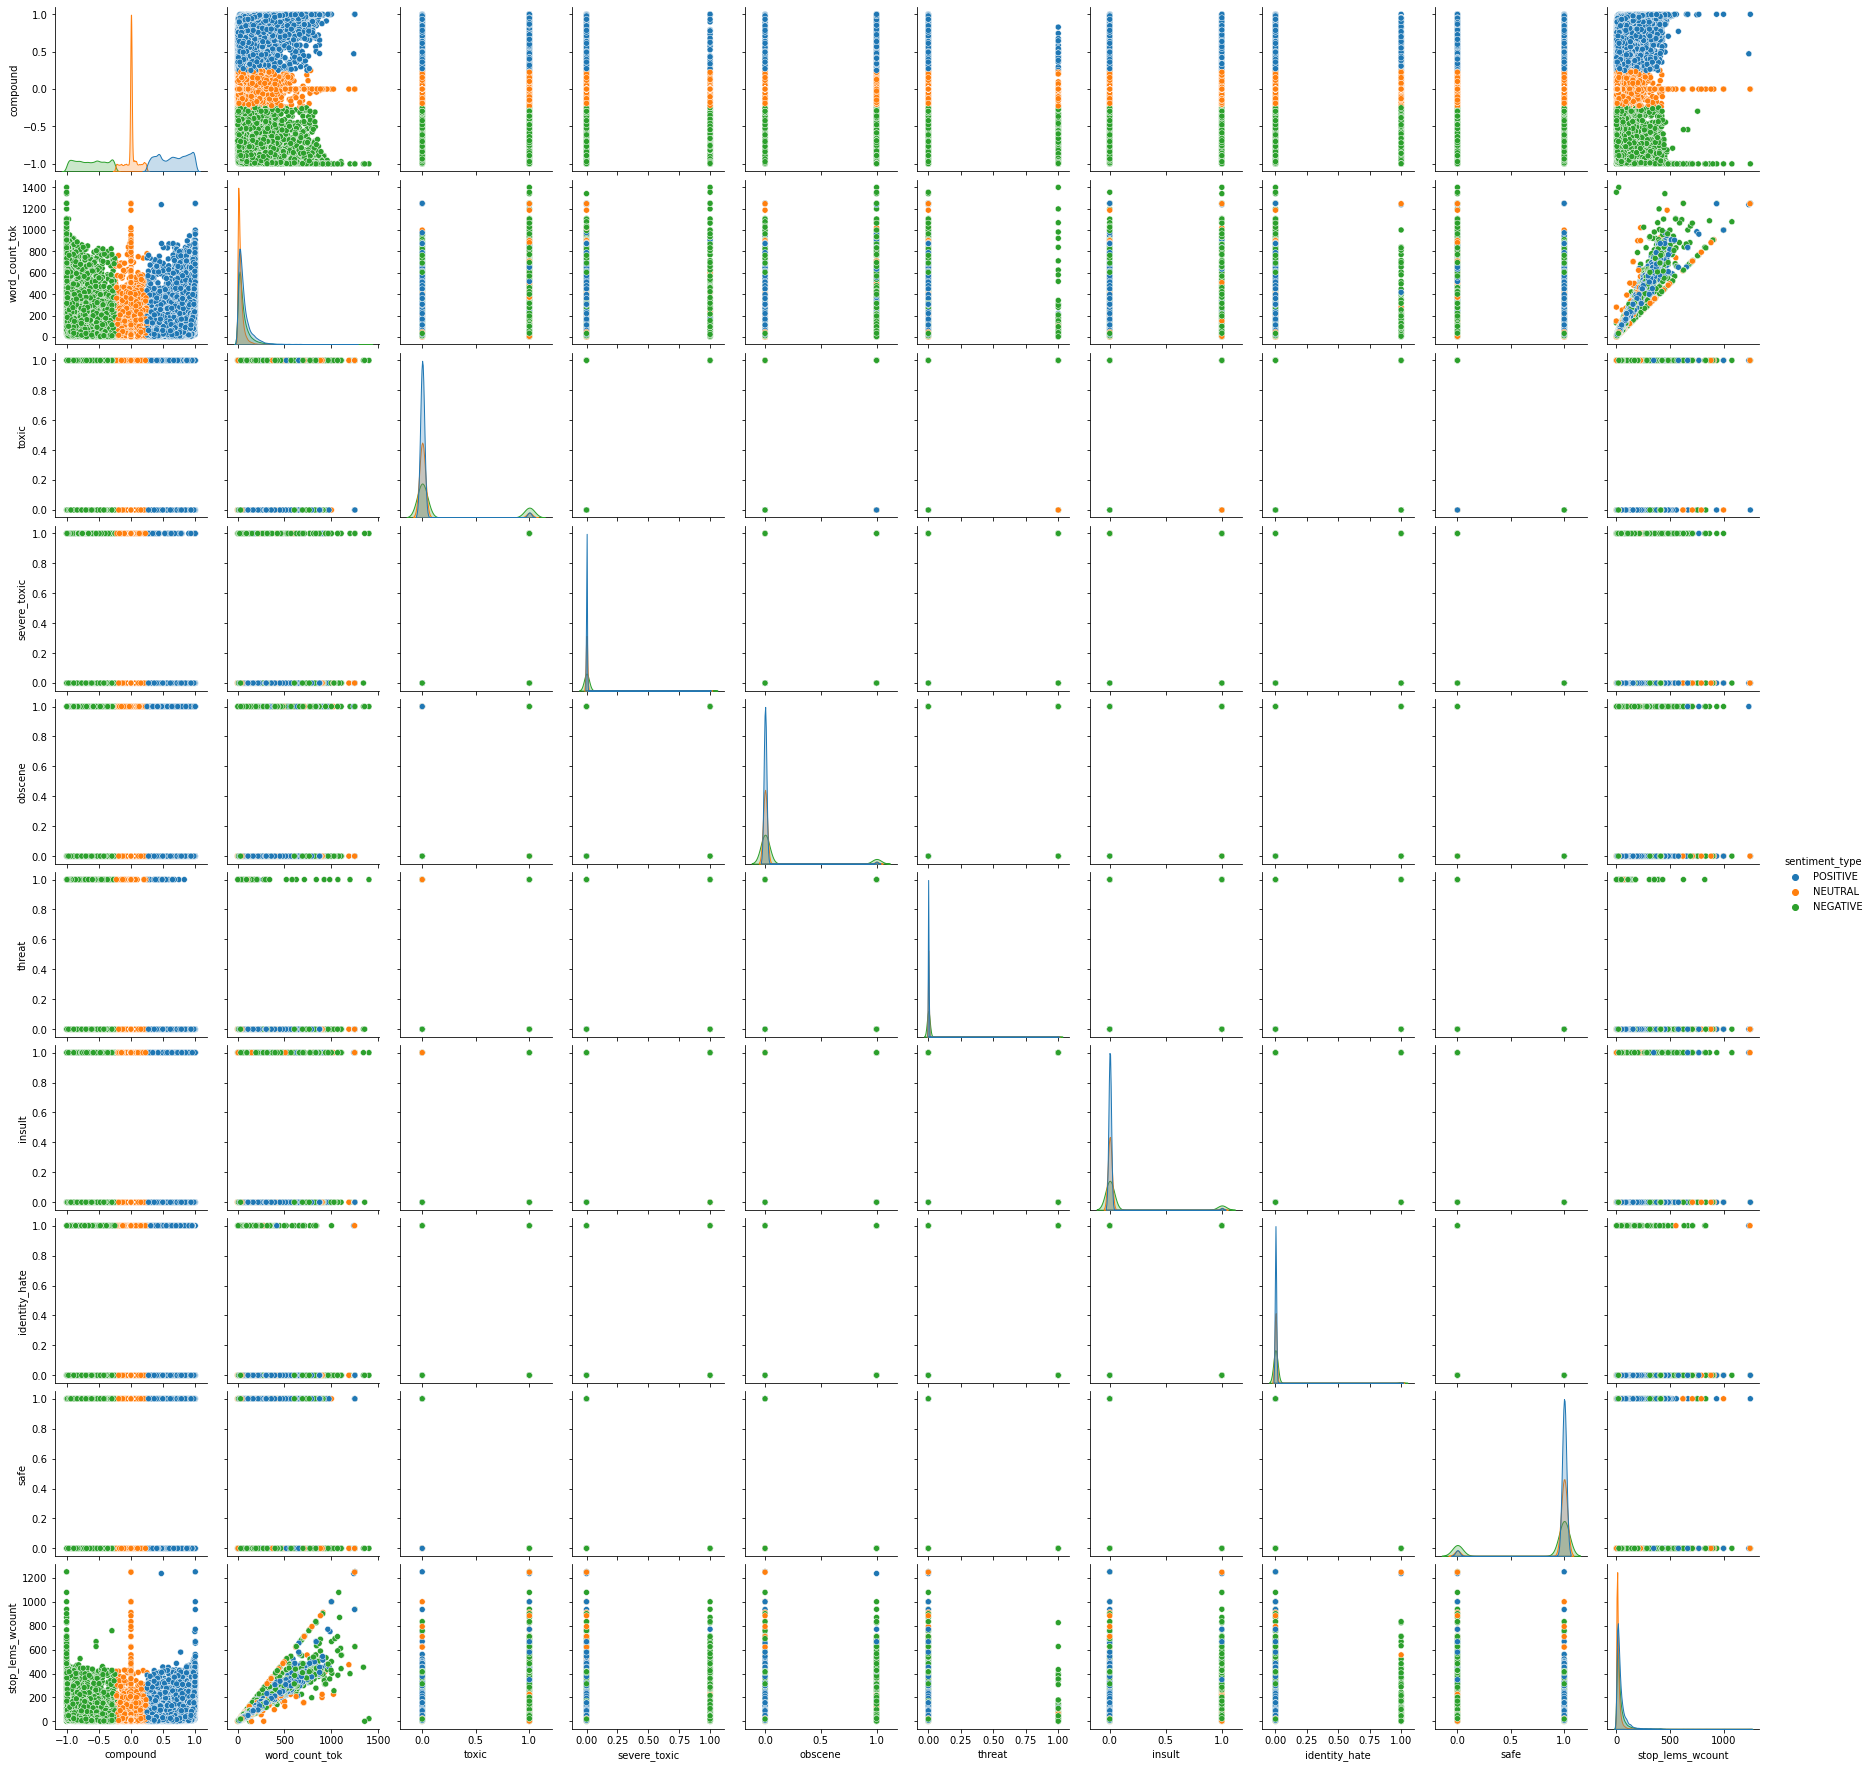

In [33]:
%%time

# Plot pairplot of numeric data with hue of the sentiment types
sns.pairplot(df, hue = 'sentiment_type')

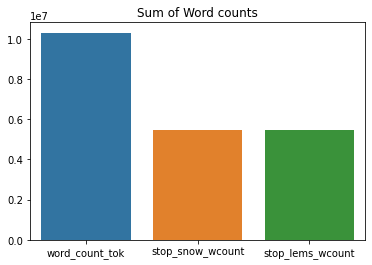

In [38]:
word_counts = ['word_count_tok','stop_snow_wcount','stop_lems_wcount']
y=df[word_counts].sum()
ab = df.groupby(word_counts).sum()

ax = sns.barplot(x=word_counts,y=y)
    
plt.title('Sum of Word counts')
plt.show();

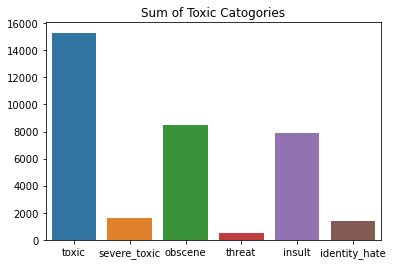

In [39]:
categories = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
sns.barplot(x=categories,y=df[categories].sum())
plt.title('Sum of Toxic Catogories')
plt.show()

### Length and Number of text

In [40]:
df['comment_length'] = df['comment_text'].map(len)

In [41]:
df['comment_wordcount'] = df['comment_text'].map(lambda x: len(x.split()))

In [42]:
df[['comment_wordcount', 'comment_length', 'comment_text']].head()

,comment_wordcount,comment_length,comment_text
0,41,230,why the edits made under my username hardcore ...
1,14,90,daww he matches this background colour im seem...
2,42,227,hey man im really not trying to edit war its j...
3,107,593,i cant make any real suggestions on improvemen...
4,13,62,you sir are my hero any chance you remember wh...


In [43]:
toxic = df[df['safe'] == 0]

In [44]:
safe = df[df['safe'] == 1]

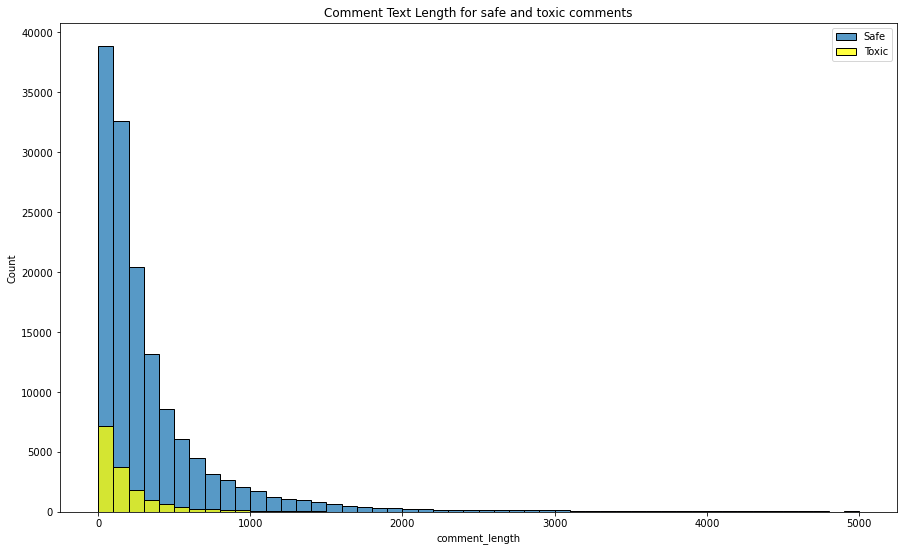

In [48]:

plt.figure(figsize = (15,9))
plt.title('Comment Text Length for safe and toxic comments')
sns.histplot(safe['comment_length'], bins = 50, label = 'Safe')
sns.histplot(toxic['comment_length'], bins = 50, color = 'yellow', label = 'Toxic')
plt.legend();


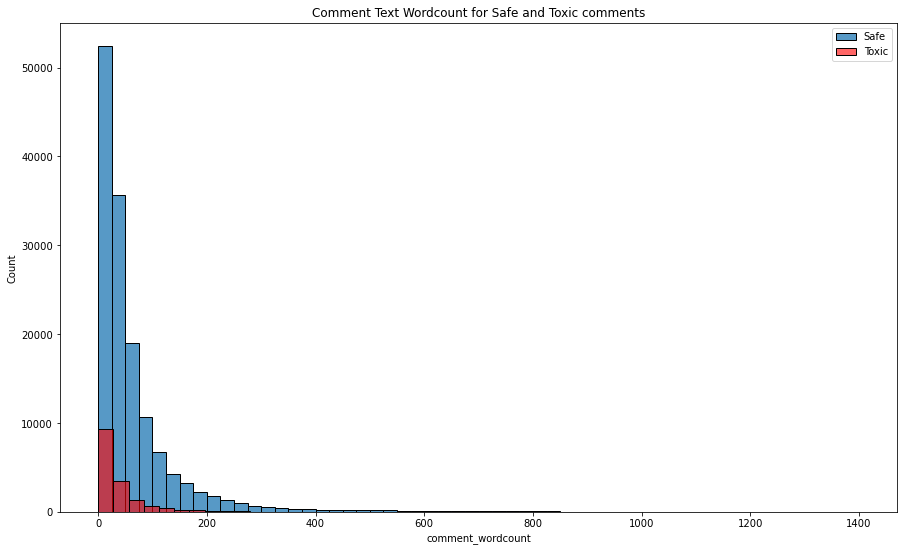

In [49]:
plt.figure(figsize = (15, 9))
plt.title('Comment Text Wordcount for Safe and Toxic comments')
sns.histplot(safe['comment_wordcount'], bins = 50, label = 'Safe')
sns.histplot(toxic['comment_wordcount'], bins = 50, color = 'red', alpha = 0.6, label = 'Toxic')
plt.legend();

In [79]:
df.sort_values(by='comment_wordcount', ascending= False)[['comment_text', 'comment_wordcount','safe']].head(10)

,comment_text,comment_wordcount,safe
4712,do go fuck off bastarddo yyou have a lifego fu...,1400,0
81295,take that in the ass in the ass in the ass in ...,1354,0
35817,what is rong with you u pervert i ahte u just ...,1341,0
27148,damn you u cunt damn you u cunt damn you u cun...,1250,0
76598,die fag die fag die fag die fag die fag die fa...,1250,0
150039,lol lol lol lol lol lol lol lol lol lol lol lo...,1250,1
61793,oh noes oh noes oh noes oh noes oh noes oh noe...,1250,1
32143,pig pig pig pig pig pig pig pig pig pig pig pi...,1250,0
136531,suck my cock d suck my cock d suck my cock d s...,1250,0
153353,fat jew fat jew fat jew fat jew fat jew fat je...,1247,0


<AxesSubplot:xlabel='comment_wordcount', ylabel='Density'>

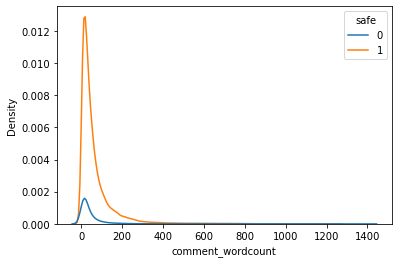

In [161]:
sns.kdeplot(data=df, x="comment_wordcount", hue="safe", )

In [80]:
df.sort_values(by='comment_length', ascending=False)[['comment_text', 'comment_length', 'safe']].head(10)

,comment_text,comment_length,safe
47715,block block block block block block block bloc...,5000,1
93952,wiki noobs wiki noobs wiki noobs wiki noobs wi...,5000,0
6201,securityfuck homeland securityfuck homeland se...,5000,0
121718,buttsecks buttsecks buttsecks buttsecks buttse...,5000,0
42061,wanker wanker wanker wanker wanker wanker wank...,5000,0
156437,huge faggot huge faggot huge faggot huge faggo...,5000,0
70544,delete this pagedelete this pagedelete this pa...,5000,1
128782,sex fucksex fucksex fucksex fucksex fucksex fu...,5000,0
34422,you suck you suck you suck you suck you suck y...,5000,0
46583,hahahahahahahahahahahahahahahahahaha vandalism...,5000,0


### Distplot of Scores per comment Catogory

In [50]:
tar_col = ['toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate',]

In [51]:
tar_col

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

<Figure size 432x288 with 0 Axes>

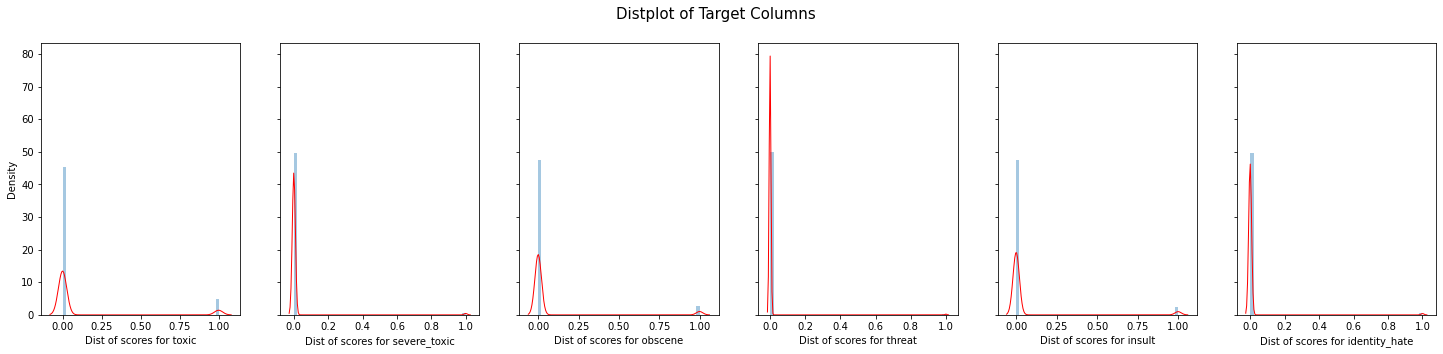

In [53]:
plt.tight_layout()
fig, axes = plt.subplots(  ncols=6, nrows =1, figsize=(25,5), sharey=True)

for i, col in enumerate(tar_col):
    sns.distplot(df[col], kde=True, label=col, ax=axes[i],kde_kws={"color": "r", "lw": 1, "label": "KDE"},)
    axes[i].set_xlabel(f'Dist of scores for {col}')

    
plt.suptitle('Distplot of Target Columns', fontsize=15)
plt.show();

<Figure size 432x288 with 0 Axes>

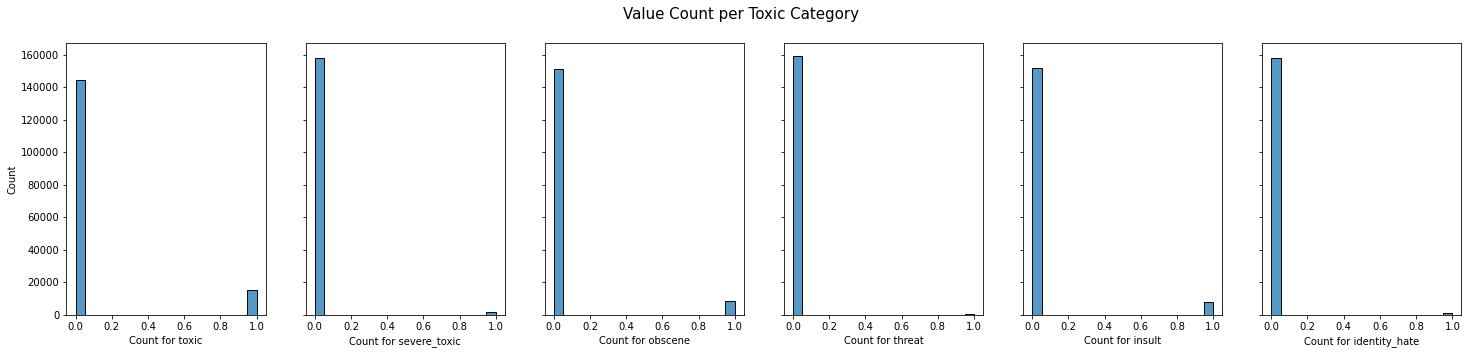

In [54]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(25,5), sharey=True)

for i, col in enumerate(tar_col):
    sns.histplot(df[col], label=col, ax=axes[i])
    axes[i].set_xlabel(f'Count for {col}')

    
plt.suptitle('Value Count per Toxic Category', fontsize=15)
plt.show();

- we can see that there is presence of data imbalance for all our labels. we will deal with the data imbalance in the modelling process utilizing 'balance weight'

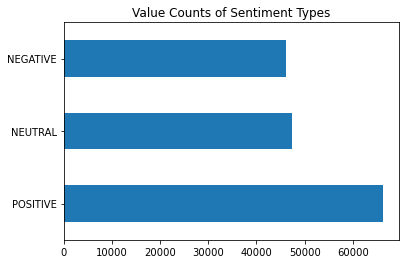

In [55]:
df['sentiment_type'].value_counts().plot(kind = 'barh', title = 'Value Counts of Sentiment Types');

- Weight of Negative and Neutral sentiments are almost similar where else positive sentiments outweighs the other sentiment type.

### HeatMap

In [56]:
# set relevant numeric features for correlation analysis 
numeric_data = ['compound', 'stop_snow_wcount', 'stop_lems_wcount', 'comment_length', 'comment_wordcount','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

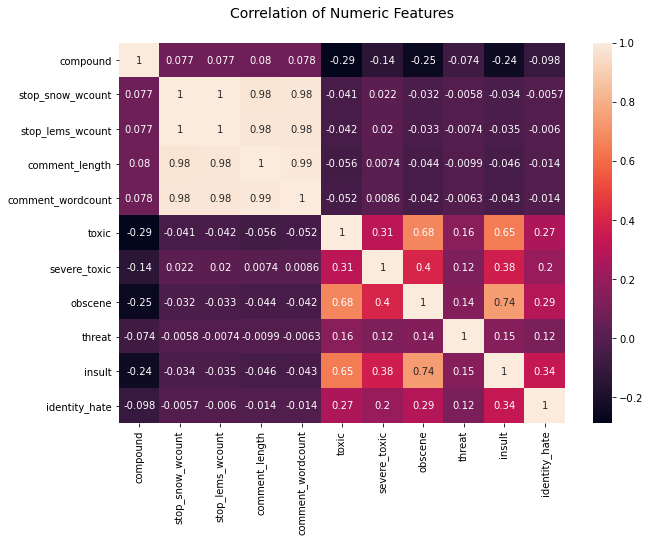

In [57]:
plt.figure(figsize=(10,7))
plt.title('Correlation of Numeric Features',y=1.05,size=14)
sns.heatmap(df[numeric_data].astype(float).corr(), annot=True);

- we can see the highly co-releated features are the word counts features which includes the lems and stemming of the the comments. this is expected as the number of word count is highly co-related to the number of text, sentence in the comment_text.
- 'insult', 'toxic' feature is moderatly co-related to 'obscence' feature. this my inccure words that are used in insult and toxic may generally appear in the obsence feature and vice viser

### Word Cloud

In [58]:
# retireve negative cols
negative_texts = df[df['safe'] == 0]

#check
negative_texts.head()

,id,comment_text,senti_scores,compound,sentiment_type,tokens,word_count_tok,toxic,severe_toxic,obscene,...,identity_hate,safe,snowball_stems,stop_snow_stems,stop_snow_wcount,lems,stop_lems,stop_lems_wcount,comment_length,comment_wordcount
6,0002bcb3da6cb337,cocksucker before you piss around on my work,"{'neg': 0.531, 'neu': 0.469, 'pos': 0.0, 'comp...",-0.7783,NEGATIVE,"[cocksucker, before, you, piss, around, on, my...",8,1,1,1,...,0,0,"[cocksuck, befor, you, piss, around, on, my, w...","[cocksuck, befor, piss, around, work]",5,"[cocksucker, before, you, piss, around, on, my...","[cocksucker, piss, around, work]",4,44,8
12,0005c987bdfc9d4b,hey what is it talk what is it an exclusive g...,"{'neg': 0.161, 'neu': 0.69, 'pos': 0.149, 'com...",-0.4019,NEGATIVE,"[hey, what, is, it, talk, what, is, it, an, ex...",49,1,0,0,...,0,0,"[hey, what, is, it, talk, what, is, it, an, ex...","[hey, talk, exclus, group, wp, talibanswho, go...",26,"[hey, what, is, it, talk, what, is, it, an, ex...","[hey, talk, exclusive, group, wp, talibanswho,...",25,291,49
16,0007e25b2121310b,bye dont look come or think of comming back to...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL,"[bye, dont, look, come, or, think, of, comming...",10,1,0,0,...,0,0,"[bye, dont, look, come, or, think, of, com, ba...","[bye, dont, look, come, think, com, back, tosser]",8,"[bye, dont, look, come, or, think, of, comming...","[bye, dont, look, come, think, comming, back, ...",8,50,10
42,001810bf8c45bf5f,you are gay or antisemmitian archangel white t...,"{'neg': 0.157, 'neu': 0.843, 'pos': 0.0, 'comp...",-0.9458,NEGATIVE,"[you, are, gay, or, antisemmitian, archangel, ...",103,1,0,1,...,1,0,"[you, are, gay, or, antisemmitian, archangel, ...","[gay, antisemmitian, archangel, white, tigerme...",54,"[you, are, gay, or, antisemmitian, archangel, ...","[gay, antisemmitian, archangel, white, tigerme...",53,567,103
43,00190820581d90ce,fuck your filthy mother in the ass dry,"{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'comp...",-0.7906,NEGATIVE,"[fuck, your, filthy, mother, in, the, ass, dry]",8,1,0,1,...,0,0,"[fuck, your, filthi, mother, in, the, ass, dri]","[fuck, filthi, mother, ass, dri]",5,"[fuck, your, filthy, mother, in, the, as, dry]","[fuck, filthy, mother, dry]",4,38,8


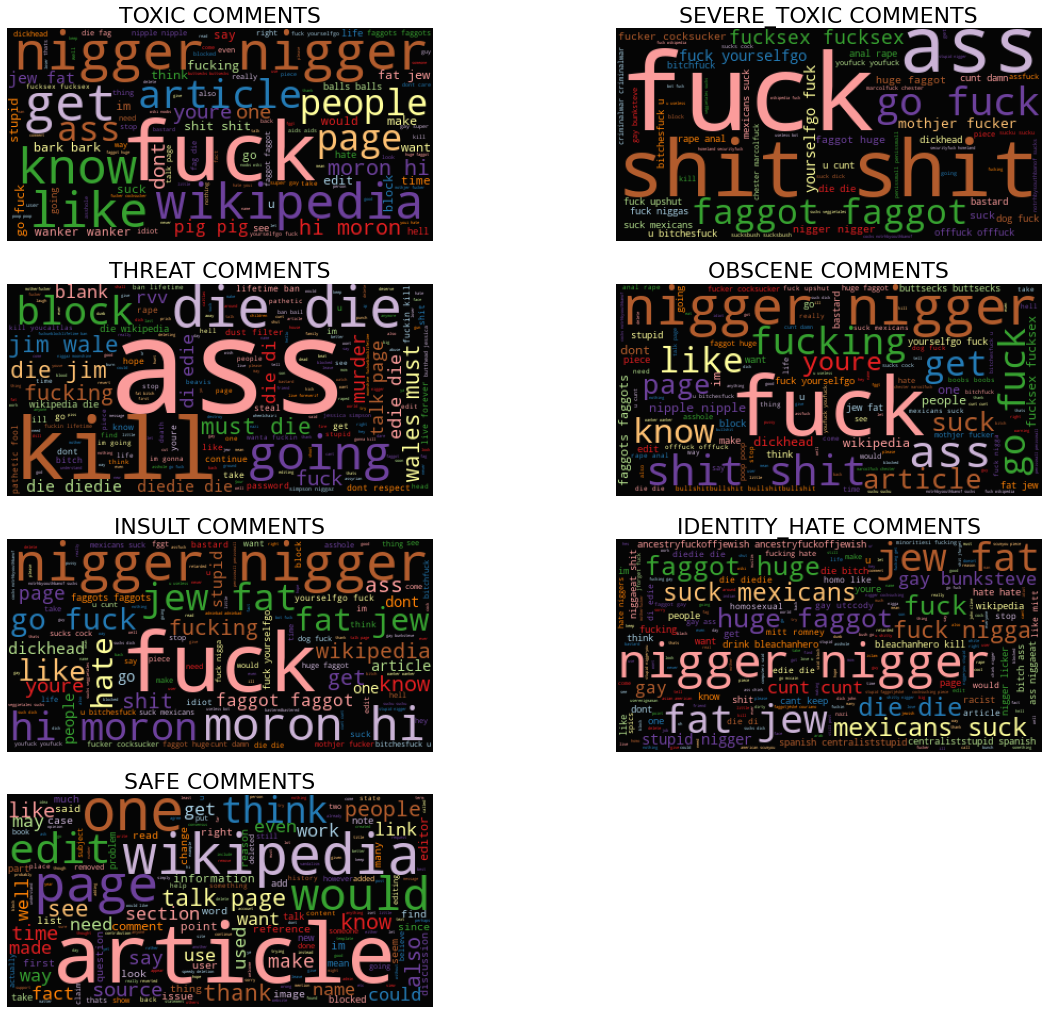

In [59]:
plt.figure(figsize=(20, 18))

for i, category in enumerate(["toxic", "severe_toxic", "threat", "obscene", "insult", "identity_hate", 'safe']):
    plt.subplot(4,2,i+1)
    wc_normal = WordCloud(max_words=200, #min_font_size=10,
                          stopwords= stop, background_color="black", 
                          random_state=42).generate(" ".join(df[df[category]==1].comment_text.values))
    plt.title("{0} comments".format(category).upper(), fontsize=22)
    plt.axis("off")
    #plt.imshow(wc_normal)
    plt.imshow(wc_normal.recolor(colormap= 'Paired_r' , random_state=42), alpha=0.98)

In [60]:
# create function for wordcloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop,
        max_words=200,
        #max_font_size=40, 
        scale=2,
        random_state=42 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud.recolor(colormap= 'Reds' , random_state=42), alpha=0.98)
    plt.show()

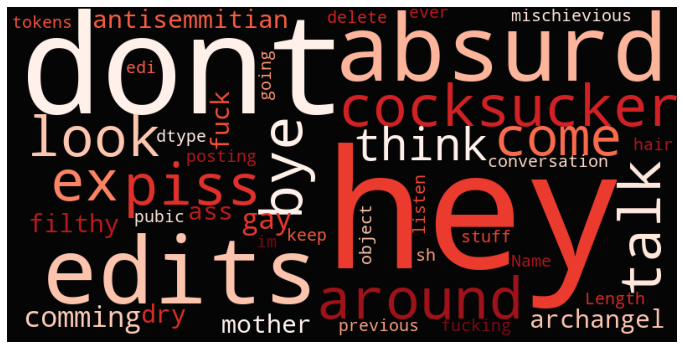

In [61]:
# display wordcloud for tokens col
show_wordcloud(negative_texts['tokens'])

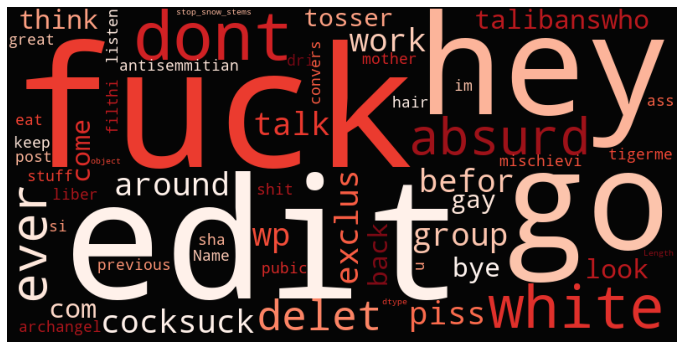

In [62]:
# display word cloud for snowball stemmer
show_wordcloud(negative_texts['stop_snow_stems'])

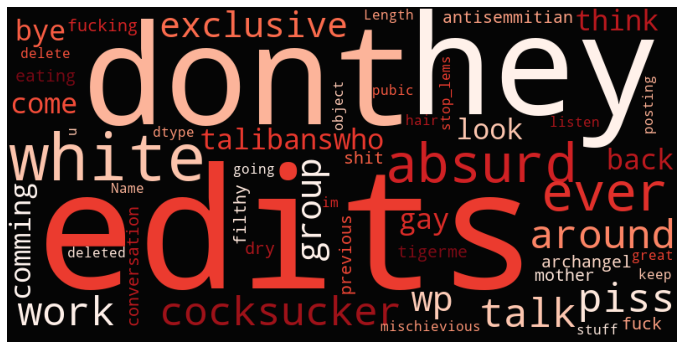

In [63]:
# display wordcloud for Lemmatization
show_wordcloud(negative_texts['stop_lems'])

### Word frequencies

- Viewing top most frequent words in each of the target catogory. we will be leveraging on the lemmatized tokens instead of the snowball tokens as lemmatized tokens gives us a clearer understanding of the language used instead of just stemmed words

In [64]:
# create function for ploting top 15 most common words for toxic words in lem col

def word_freq(col, stem_col):
    safe_stem= []
    not_safe_stem = []

    for i in df.index:
    
        #not safe = 0 , safe_stem words. 
        if df[col][i] ==0:
            not_safe_stem.append(df[stem_col][i])
        #safe = 1 , not_safe words. 
        if  df[col][i] ==1:
            safe_stem.append(df[stem_col][i])  

    not_safe_comp = []        
    for wordlist in not_safe_stem:
        w1 = ' '.join(wordlist)
        not_safe_comp.append(w1)
    all_notsafe_stems = ' '.join(not_safe_comp)
      
    tokens = nltk.tokenize.word_tokenize(all_notsafe_stems)
    freqs = FreqDist(tokens).most_common(15)

    x= [x[0] for x in freqs]
    y= [x[1] for x in freqs]

    plt.xticks(rotation = 45)
    return sns.barplot(x=x, y=y).set_title(f"Not Safe comments Most Common Words {stem_col}");

Text(0.5, 1.0, 'Not Safe comments Most Common Words stop_lems')

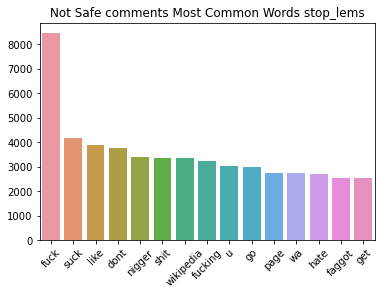

In [65]:
word_freq('safe', 'stop_lems')

Text(0.5, 1.0, 'Not Safe comments Most Common Words stop_snow_stems')

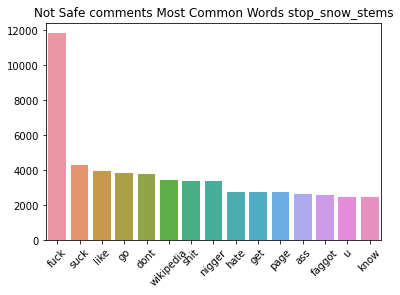

In [66]:
# plot word freq of snow stems to view if any large difference
word_freq('safe', 'stop_snow_stems')

In [67]:
# create function for ploting top 15 most common words for where value = 1

def word_freq_safe(col, stem_col):
    safe_stem= []
    not_safe_stem = []

    for i in df.index:
    
        #not safe = 0 , so these are all the star trek stem words. 
        if df[col][i] ==0:
            not_safe_stem.append(df[stem_col][i])
        #safe = 1 , so these are all the star wars stem words. 
        if  df[col][i] ==1:
            safe_stem.append(df[stem_col][i])  

    safe_comp = []
    for wordlist in safe_stem:
        w2 = ' '.join(wordlist)
        safe_comp.append(w2)
    all_safe_stems = ' '.join(safe_comp)
        
    tokens = nltk.tokenize.word_tokenize(all_safe_stems)
    freqs = FreqDist(tokens).most_common(15)

    x= [x[0] for x in freqs]
    y= [x[1] for x in freqs]

    plt.xticks(rotation = 45)
    return sns.barplot(x=x, y=y).set_title(f"Most Common Words {col}, {stem_col}");

Text(0.5, 1.0, 'Most Common Words safe, stop_lems')

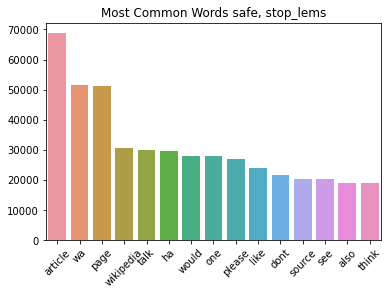

In [68]:
word_freq_safe('safe', 'stop_lems')

Text(0.5, 1.0, 'Most Common Words toxic, stop_lems')

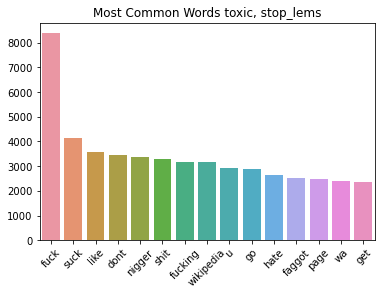

In [69]:
word_freq_safe('toxic', 'stop_lems')

Text(0.5, 1.0, 'Most Common Words severe_toxic, stop_lems')

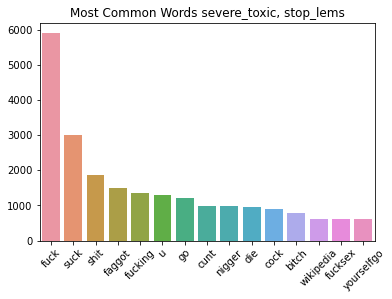

In [70]:
word_freq_safe('severe_toxic', 'stop_lems')

Text(0.5, 1.0, 'Most Common Words obscene, stop_lems')

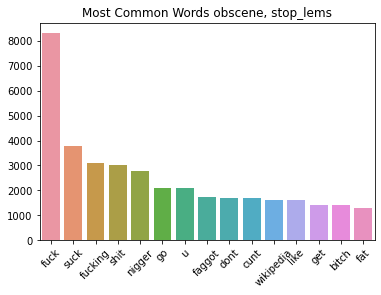

In [71]:
word_freq_safe('obscene', 'stop_lems')

Text(0.5, 1.0, 'Most Common Words threat, stop_lems')

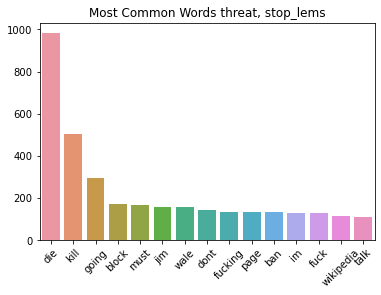

In [72]:
word_freq_safe('threat', 'stop_lems')

Text(0.5, 1.0, 'Most Common Words insult, stop_lems')

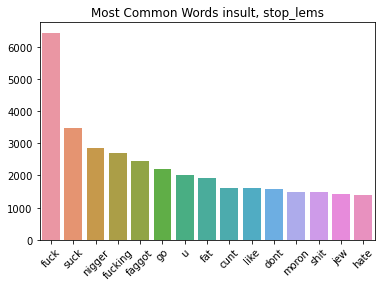

In [73]:
word_freq_safe('insult', 'stop_lems')

Text(0.5, 1.0, 'Most Common Words identity_hate, stop_lems')

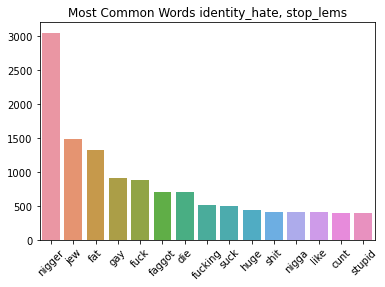

In [74]:
word_freq_safe('identity_hate', 'stop_lems')

### Export Data

In [75]:
#re organise columns
df = df[['id', 'comment_text', 'senti_scores','compound','sentiment_type','tokens','snowball_stems', 'stop_snow_stems', 'lems', 'stop_lems' ,'word_count_tok', 'stop_lems_wcount', 'comment_length', 'comment_wordcount','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate','safe' ]]

In [76]:
df.head()

,id,comment_text,senti_scores,compound,sentiment_type,tokens,snowball_stems,stop_snow_stems,lems,stop_lems,...,stop_lems_wcount,comment_length,comment_wordcount,toxic,severe_toxic,obscene,threat,insult,identity_hate,safe
0,0000997932d777bf,why the edits made under my username hardcore ...,"{'neg': 0.0, 'neu': 0.892, 'pos': 0.108, 'comp...",0.5574,POSITIVE,"[why, the, edits, made, under, my, username, h...","[whi, the, edit, made, under, my, usernam, har...","[whi, edit, made, usernam, hardcor, metallica,...","[why, the, edits, made, under, my, username, h...","[edits, made, username, hardcore, metallica, f...",...,25,230,41,0,0,0,0,0,0,1
1,000103f0d9cfb60f,daww he matches this background colour im seem...,"{'neg': 0.118, 'neu': 0.71, 'pos': 0.172, 'com...",0.2263,NEUTRAL,"[daww, he, matches, this, background, colour, ...","[daww, he, match, this, background, colour, im...","[daww, match, background, colour, im, seem, st...","[daww, he, match, this, background, colour, im...","[daww, match, background, colour, im, seemingl...",...,11,90,14,0,0,0,0,0,0,1
2,000113f07ec002fd,hey man im really not trying to edit war its j...,"{'neg': 0.083, 'neu': 0.849, 'pos': 0.068, 'co...",-0.1779,NEUTRAL,"[hey, man, im, really, not, trying, to, edit, ...","[hey, man, im, realli, not, tri, to, edit, war...","[hey, man, im, realli, tri, edit, war, guy, co...","[hey, man, im, really, not, trying, to, edit, ...","[hey, man, im, really, trying, edit, war, guy,...",...,22,227,42,0,0,0,0,0,0,1
3,0001b41b1c6bb37e,i cant make any real suggestions on improvemen...,"{'neg': 0.044, 'neu': 0.893, 'pos': 0.063, 'co...",0.2500,POSITIVE,"[i, cant, make, any, real, suggestions, on, im...","[i, cant, make, ani, real, suggest, on, improv...","[cant, make, ani, real, suggest, improv, wonde...","[i, cant, make, any, real, suggestion, on, imp...","[cant, make, real, suggestion, improvement, wo...",...,50,593,107,0,0,0,0,0,0,1
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp...",0.6808,POSITIVE,"[you, sir, are, my, hero, any, chance, you, re...","[you, sir, are, my, hero, ani, chanc, you, rem...","[sir, hero, ani, chanc, rememb, page]","[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page, thats]",...,6,62,13,0,0,0,0,0,0,1


In [77]:
# will need to run this for part 2 of the project
df.to_pickle('./datasets/df.pkl')